# 1) Get items which are recyclable

These are the items our image recognition model has to be able to identify.

In [2]:
from typing import Text, List
import requests

import pandas as pd
import numpy as np


def html_to_df(source: Text,
               path: Text) -> List[pd.DataFrame]:
    """
    Convert html to list of pandas dataframes

    :param source: Source of html, either 'url' or 'file'
    :param path: If source is 'url', enter url. If source if 'file',
                 enter file path
    """
    if source == "url":
        r = requests.get(path)
        r_html = r.text
    elif source == "file":
        with open(path) as f:
            r_html = f.read()

    r_df_list = pd.read_html(r_html)

    return r_df_list


def get_zerowastesg_recyclables(source: Text,
                                path: Text) -> pd.DataFrame:
    """
    Get recyclables from zerowastesg.

    :param source: Source of html, either 'url' or 'file'
    :param path: If source is 'url', enter url. If source if 'file',
                 enter file path
    """
    # Get zerowaste df
    zws_df_list = html_to_df(source=source,
                             path=path)

    zws_df = pd.DataFrame()
    for df in zws_df_list:
        # Get item type
        item_type = df.columns[0]
        item_type = item_type.split()[0]

        # Split df for recyclables and non-recyclables
        df_recyclable = df.iloc[:, 0:2]
        df_recyclable.columns = ["item", "remarks"]
        df_recyclable['is_recyclable'] = True

        df_non_recyclable = df.iloc[:, 2:4]
        df_non_recyclable.columns = ["item", "remarks"]
        df_non_recyclable['is_recyclable'] = False

        # Format df
        df_group = df_recyclable.append(df_non_recyclable)
        df_group['group'] = item_type

        df_group['item'] = df_group['item'].replace("-", np.nan)
        df_group = df_group.dropna(subset=['item'])
        df_group['item'] = df_group['item'].apply(lambda x: ' '.join(x.split()[1:]))
        zws_df = zws_df.append(df_group)

    zws_df = zws_df.reset_index(drop=True)

    return zws_df

zws_df = get_zerowastesg_recyclables(source="url",
                                     path="http://www.zerowastesg.com/recycle/")

/home/laura/Documents/trashy-image-recognition/venv/lib/python3.5/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)
/home/laura/Documents/trashy-image-recognition/venv/lib/python3.5/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/laura/Documents/trashy-image-recognition/venv/lib/python3.5/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
recyclables = list(zws_df['item'])

# 2a) Get all 1000 items from Imagenet

In [4]:
import requests

from bs4 import BeautifulSoup

# Get html from webpage
r = requests.get("http://image-net.org/challenges/LSVRC/2014/browse-synsets")

# Extract html from main div
soup = BeautifulSoup(r.text)
result = soup.find("div", {"id" : "main"})

# Get all 1000 classifications
classification_dict = {}
classes = []
get = False

for classification in result.findAll('a'):
    text = classification.text
    
    if text == 'kit fox, Vulpes macrotis':
        get = True
            
    if get:
        classes.append(classification.text)

/home/laura/Documents/trashy-image-recognition/venv/lib/python3.5/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file /usr/lib/python3.5/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


# 2b) Find which recyclable items are not in Imagenet's list

All items are not in Imagenet's list when we do a direct matching

In [5]:
len(set(recyclables))

80

In [6]:
len(set(recyclables) - set(classes))

80

# 2c) Test what these items are classified as by Inception V3

* Get 30 images
* Print images
* Run through algo
* Return classification by Inception

In [7]:
import os
import pickle

In [8]:
import sys
sys.path.append('../')

from models.imagenet.custom_classify_image import get_softmax_vector
from google_images_download import google_images_download

response = google_images_download.googleimagesdownload()

In [18]:
# Get 30 images for each recyclable item

for item in recyclables:
    if item not in os.listdir("../training_images/"):
        absolute_image_paths = response.download({
            'keywords': item, 
            'limit': 30,
            'format': 'jpg',
            'output_directory': '../training_images'})


Item no.: 1 --> Item name = Plastic containers
Evaluating...
Starting Download...
Completed Image ====> 1. 71i6GQ4TmXL._SX425_.jpg
Completed Image ====> 2. kitchen-plastic-container-1500-500x500.jpg
Completed Image ====> 3. 10008758-our-accessory-box.jpg
Completed Image ====> 4. 236854.jpg&height=940&width=940.jpg
Completed Image ====> 5. 81JXRTL5ApL._SX425_.jpg
Completed Image ====> 6. s-l300.jpg
Completed Image ====> 7. 160976.jpg&height=475&width=475.jpg
Completed Image ====> 8. A1r6LsriEoL._SX466_.jpg
Completed Image ====> 9. 1131390.jpg
Completed Image ====> 10. 750cl-take-away-container-l.jpg
Completed Image ====> 11. clear-bottom-w-white-lid-and-blue-aquarium-latches-sterilite-storage-bins-14978006-64_1000.jpg
Completed Image ====> 12. plastic-container-500x500.jpg
Completed Image ====> 13. s-l300.jpg
Completed Image ====> 14. bc6cde91ae0ce04080a97adb2824b4ee.jpg
IOError on an image...trying next one... Error: The read operation timed out
Completed Image ====> 15. 05
Completed 

In [ ]:
# Get softmax vector for each image

counter = 1
for obj in os.listdir("../training_images/"):
    print('Processing ' + obj + '...')    
    
    # If softmax vector is already saved, don't generate it again.
    if obj + ".txt" in os.listdir("../training_vectors/"):
        continue
    
    else:
        smv_obj = []

        for file in os.listdir(os.path.join("../training_images", obj)):
            smv = get_softmax_vector(os.path.join("../training_images", obj, file))
            smv_obj.append(smv)

        with open(os.path.join("../training_vectors", obj) + ".txt", "wb") as fp:
            pickle.dump(smv_obj, fp)
            print("Softmax vector saved.")
        
    counter += 1
    
    if counter > 5:
        break

Processing Aluminium trays and foil...
Processing Calendar...
Processing Old clothes (in good condition)...
Processing Beverage bottles...
Processing Pens and pencils...
Processing Food cans...
Processing  trays and tubs for food (non-polystyrene)...
Processing Ceramics...
Processing Tissue box...
Processing Paper wrapper for food...
Processing Egg tray...
Instructions for updating:
Use tf.gfile.GFile.
Softmax vector saved.
Processing Household batteries...
Softmax vector saved.
Processing Toilet paper...
Softmax vector saved.
Processing Gift wrapping paper...
Softmax vector saved.
Processing Flyer...


In [19]:
smv_objs = {}

for obj in os.listdir("../training_vectors/"):
    print('Loading ' + obj + '...')
    
    with open(os.path.join("../training_vectors", obj), "rb") as fp:
        b = pickle.load(fp)

        smv_objs[obj.strip('.txt')] = b

Loading Beverage bottles.txt...
Loading Aluminium trays and foil.txt...
Loading Old clothes (in good condition).txt...
Loading Calendar.txt...
Loading Pens and pencils.txt...
Loading Food cans.txt...


In [10]:
from sklearn.manifold import TSNE

/home/laura/Documents/trashy-image-recognition/venv/lib/python3.5/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
smv_lists = []
smv_groups = []

for k in smv_objs.keys():
    smv_list = smv_objs.get(k)
    smv_lists.extend(smv_list)
    
    smv_group = [k] * len(smv_list)
    smv_groups.extend(smv_group)

In [21]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(smv_lists)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 176 samples in 0.003s...
[t-SNE] Computed neighbors for 176 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 176 / 176
[t-SNE] Mean sigma: 0.262018
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.372749
[t-SNE] KL divergence after 300 iterations: 0.888240


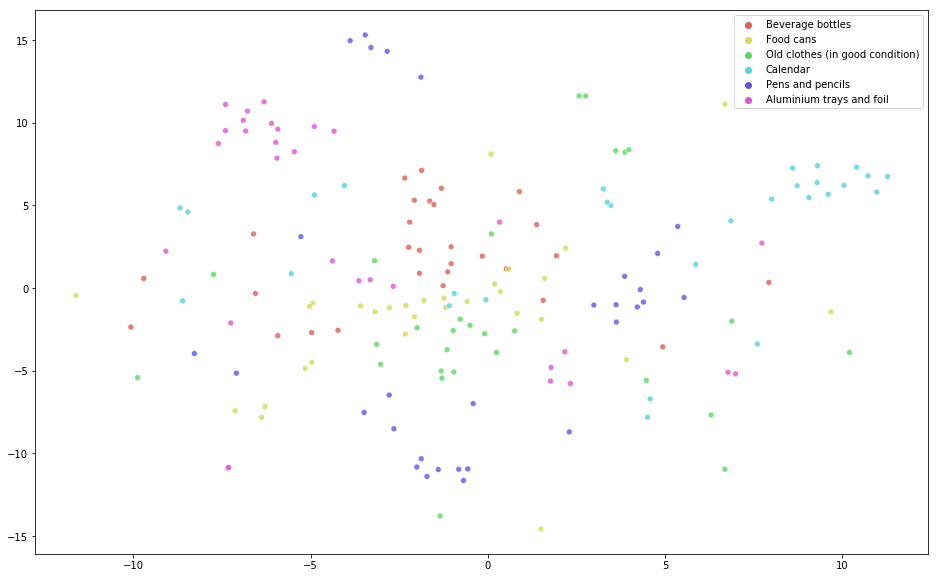

In [22]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=smv_groups,
    palette=sns.color_palette("hls", len(set(smv_groups))),
    legend="full",
    alpha=0.8)